In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from statsmodels.regression.linear_model import OLS
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Performance Evaluation Function

In [2]:
def perf_eval(target, haty):
    # Mean squeared error (MSE)
    MSE = mean_squared_error(target, haty)
    # Root mean squared error (RMSE)
    RMSE = np.sqrt(MSE)
    # Mean absolute error
    MAE = mean_absolute_error(target, haty)
    # Mean absolute percentage error
    MAPE = np.mean(np.abs((target-haty)/target))
    
    return (MSE, RMSE, MAE, MAPE)

In [3]:
perf_table = pd.DataFrame(
    data    = np.zeros((5, 4)), 
    columns = ["MSE", "RMSE", "MAE", "MAPE"],
    index   = ["MLR", "ANN", "Bagging ANN", "GBM", "Random Forests"]
)

In [4]:
perf_table

,MSE,RMSE,MAE,MAPE
MLR,0.0,0.0,0.0,0.0
ANN,0.0,0.0,0.0,0.0
Bagging ANN,0.0,0.0,0.0,0.0
GBM,0.0,0.0,0.0,0.0
Random Forests,0.0,0.0,0.0,0.0


# Read data file

In [5]:
corolla = pd.read_csv("Toyota_Corolla.csv")

In [6]:
# Split the data into the training/validation sets
np.random.seed(12345)
trn_idx = np.random.choice(corolla.index, round(0.7*corolla.shape[0]), replace=False)
trn_data = corolla.loc[trn_idx, :]
tst_data = corolla.drop(trn_idx, axis=0)

# Part 1: Regression with Single Model

## Model 1: Multiple Linear Regression with forward variable selection

In [7]:
# Variable selection: Forward selection

def forward_step_selection(data, target, max_variables=None):
    """
    Perform forward step selection on a linear regression model using AIC
    :param data: DataFrame with independent variables
    :param target: string, name of the target variable
    :param max_variables: int, maximum number of variables to include in the model (default: None)
    :return: list of selected variables at each step
    """
    # Initialize variables
    selected_vars = []
    min_aic = float("inf")
    prev_aic = float("inf")
    aic_diff = []
    
    if max_variables is None:
        max_variables = data.shape[1]
        
    # Loop over all possible variables
    for i in range(data.shape[1]):

        # Loop over all possible new variables
        for j in range(len(selected_vars), data.shape[1]):
            if data.columns[j] in selected_vars:
                continue
                
            # Add new variable to current set
            vars_to_test = selected_vars + [data.columns[j]]
            
            # Fit linear regression model
            model = OLS(target, data[vars_to_test])
            results = model.fit()
            
            # Compare AIC with minimum AIC
            if results.aic < min_aic:
                min_aic = results.aic
                new_var = data.columns[j]
                
        # Add new variable to selected variables
        if new_var in selected_vars:
            continue
        else:
            selected_vars.append(new_var)
            
        # Add next min_aic
        if prev_aic == min_aic:
            continue
        else:
            aic_diff.append(min_aic)
            prev_aic = min_aic
        
        if len(selected_vars) >= max_variables:
            break
            
    return selected_vars, aic_diff


In [8]:
# Upperbound formula
tmp_x = " + ".join(corolla.columns[1:])
tmp_xy = f"Price ~ {tmp_x}"

print(tmp_xy)

Price ~ Age_08_04 + Mfg_Month + Mfg_Year + KM + HP + Met_Color + Automatic + cc + Doors + Gears + Quarterly_Tax + Weight + Mfr_Guarantee + BOVAG_Guarantee + Guarantee_Period + ABS + Airbag_1 + Airbag_2 + Airco + Automatic_airco + Boardcomputer + CD_Player + Central_Lock + Powered_Windows + Power_Steering + Radio + Mistlamps + Sport_Model + Backseat_Divider + Metallic_Rim + Radio_cassette + Tow_Bar + Petrol + Diesel + CNG


In [9]:
selected_vars, aic_diff = forward_step_selection(
    data   = trn_data.drop('Price', axis=1), 
    target = trn_data['Price']
)

In [10]:
trn_data.drop('Price', axis=1).shape

(1005, 35)

In [11]:
len(selected_vars)

18

In [12]:
MLR_model = OLS(trn_data['Price'], trn_data[selected_vars]).fit()

In [13]:
len(selected_vars)

18

In [14]:
print(MLR_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              2923.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):                        0.00
Time:                        23:56:32   Log-Likelihood:                         -8808.8
No. Observations:                1005   AIC:                                  1.765e+04
Df Residuals:                     987   BIC:                                  1.774e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

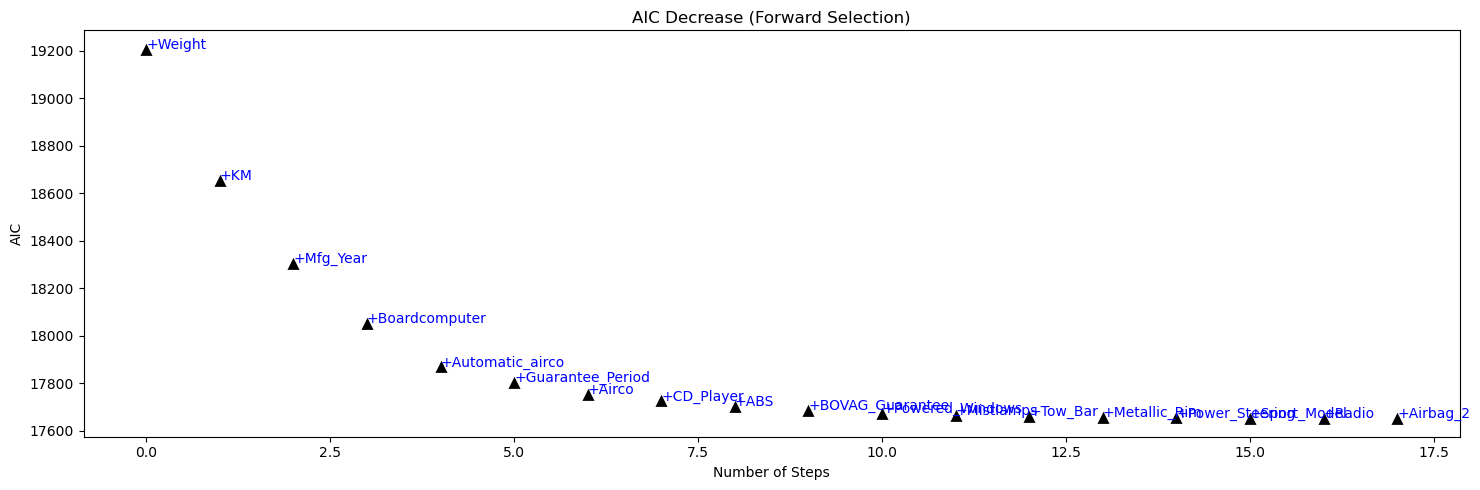

In [15]:
# Show the selected variable in each step
plt.figure(figsize=(15,5))
sns.scatterplot(
    x      = range(len(aic_diff)),
    y      = aic_diff,
    marker = '^',
    s      = 100,
    color  = 'black'
)

for i, s in enumerate(selected_vars):
    plt.text(i, aic_diff[i], f'+{s}', color='blue')

plt.title('AIC Decrease (Forward Selection)')
plt.xlabel('Number of Steps')
plt.ylabel('AIC')
plt.tight_layout()
plt.show()

In [16]:
MLR_haty = MLR_model.predict(tst_data[selected_vars])
perf_table.iloc[0, :] = perf_eval(tst_data['Price'], MLR_haty)
perf_table.round(4)

,MSE,RMSE,MAE,MAPE
MLR,2.337091e+06,1528.7547,1128.5443,0.1104
ANN,0.000000e+00,0.0000,0.0000,0.0000
Bagging ANN,0.000000e+00,0.0000,0.0000,0.0000
GBM,0.000000e+00,0.0000,0.0000,0.0000
Random Forests,0.000000e+00,0.0000,0.0000,0.0000


## Model 2: Artificial Neural Network

In [17]:
corolla_input = corolla.iloc[:, 1:]
corolla_target = corolla.iloc[:, 0]

# Data normalization
scaler = StandardScaler()
corolla_input.loc[:,:] = scaler.fit_transform(corolla_input)

# Input/Target configuration
ANN_trn_input = corolla_input.iloc[trn_idx,:]
ANN_trn_target = corolla_target[trn_idx]

ANN_tst_input = corolla_input.drop(trn_idx, axis=0)
ANN_tst_target = corolla_target.drop(trn_idx)

# Trainin ANN
ANN_model = MLPRegressor(hidden_layer_sizes=(32,), max_iter=5000, alpha=0.0005, random_state=42)
ANN_model.fit(ANN_trn_input, ANN_trn_target)

# Performance evaluation
ANN_haty = ANN_model.predict(ANN_tst_input)

perf_table.iloc[1,:] = perf_eval(tst_data['Price'], ANN_haty)
perf_table.round(4)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34660\3582876540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corolla_input.loc[:,:] = scaler.fit_transform(corolla_input)
c:\Users\se99a\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


,MSE,RMSE,MAE,MAPE
MLR,2.337091e+06,1528.7547,1128.5443,0.1104
ANN,1.823912e+06,1350.5228,986.0619,0.1010
Bagging ANN,0.000000e+00,0.0000,0.0000,0.0000
GBM,0.000000e+00,0.0000,0.0000,0.0000
Random Forests,0.000000e+00,0.0000,0.0000,0.0000


# Part 2: Regression with Ensemble Models

## Model 3: Bagging with Neural Network

In [18]:
# Bagging Training
Bagging_ANN_model = BaggingRegressor(
    base_estimator = MLPRegressor(hidden_layer_sizes=(32,), max_iter=5000, alpha=0.0005, random_state=42), 
    n_estimators   = 100, 
    n_jobs         = -1, 
    verbose        = 1
)
Bagging_ANN_model.fit(ANN_trn_input, ANN_trn_target)

# Bagging Test
Bagging_ANN_haty = Bagging_ANN_model.predict(ANN_tst_input)

perf_table.iloc[2,:] = perf_eval(tst_data['Price'], Bagging_ANN_haty)
perf_table.round(4)

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  9.9min remaining: 29.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 10.6min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.9s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.2s finished


,MSE,RMSE,MAE,MAPE
MLR,2.337091e+06,1528.7547,1128.5443,0.1104
ANN,1.823912e+06,1350.5228,986.0619,0.1010
Bagging ANN,1.720403e+06,1311.6415,987.9617,0.1007
GBM,0.000000e+00,0.0000,0.0000,0.0000
Random Forests,0.000000e+00,0.0000,0.0000,0.0000


## Model 4: Gradient Boosting Machine 

In [19]:
# Training the GBM
GBM_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.02, subsample=0.8, random_state=42)
GBM_model.fit(trn_data.iloc[:,1:], trn_data.iloc[:,0])

# Prediction
GBM_haty = GBM_model.predict(tst_data.iloc[:,1:])

perf_table.iloc[3,:] = perf_eval(tst_data['Price'], GBM_haty)
perf_table.round(4)

,MSE,RMSE,MAE,MAPE
MLR,2.337091e+06,1528.7547,1128.5443,0.1104
ANN,1.823912e+06,1350.5228,986.0619,0.1010
Bagging ANN,1.720403e+06,1311.6415,987.9617,0.1007
GBM,9.573357e+05,978.4353,741.5898,0.0741
Random Forests,0.000000e+00,0.0000,0.0000,0.0000


In [20]:
# Feature Importance
var_imp = GBM_model.feature_importances_

var_imp_df = pd.DataFrame(
    data = var_imp,
    columns = ['variables importance'],
    index = tst_data.iloc[:,1:].columns
).sort_values('variables importance', ascending=False)

var_imp_df

,variables importance
Age_08_04,0.564246
Mfg_Year,0.249784
Weight,0.063942
KM,0.051275
HP,0.016401
Quarterly_Tax,0.009683
Automatic_airco,0.008324
Powered_Windows,0.003882
Airco,0.003779
Guarantee_Period,0.003101


<Axes: xlabel='variables importance'>

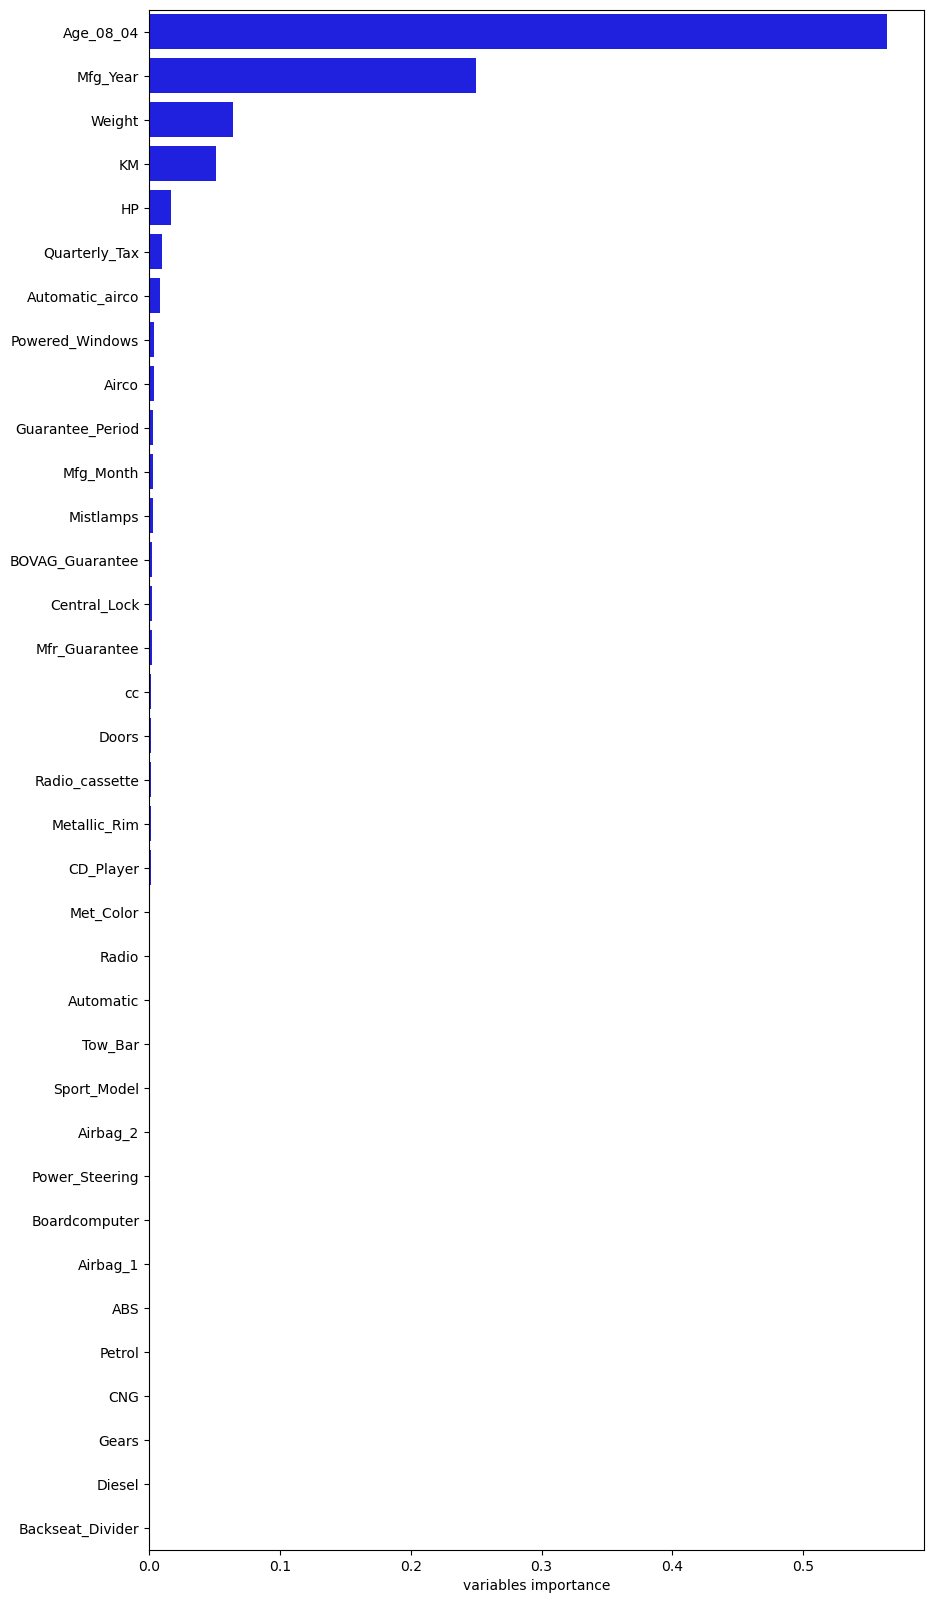

In [21]:
plt.figure(figsize=(10,20))
sns.barplot(
    x = 'variables importance',
    y = var_imp_df.index,
    color = 'blue',
    data = var_imp_df
)

## Model 5: Random Forest

In [22]:
# Training the Random Forest
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(trn_data.iloc[:,1:], trn_data.iloc[:,0])

RandomForestRegressor(random_state=42)

In [23]:
# Feature Importance
var_imp = RF_model.feature_importances_

var_imp_df = pd.DataFrame(
    data = var_imp,
    columns = ['variables importance'],
    index = tst_data.iloc[:,1:].columns
).sort_values('variables importance', ascending=False)

var_imp_df

,variables importance
Age_08_04,0.462084
Mfg_Year,0.362981
Weight,0.060512
KM,0.041148
Quarterly_Tax,0.011720
HP,0.009079
Mfg_Month,0.006461
Metallic_Rim,0.005272
Automatic_airco,0.004016
Airco,0.003103


<Axes: ylabel='variables importance'>

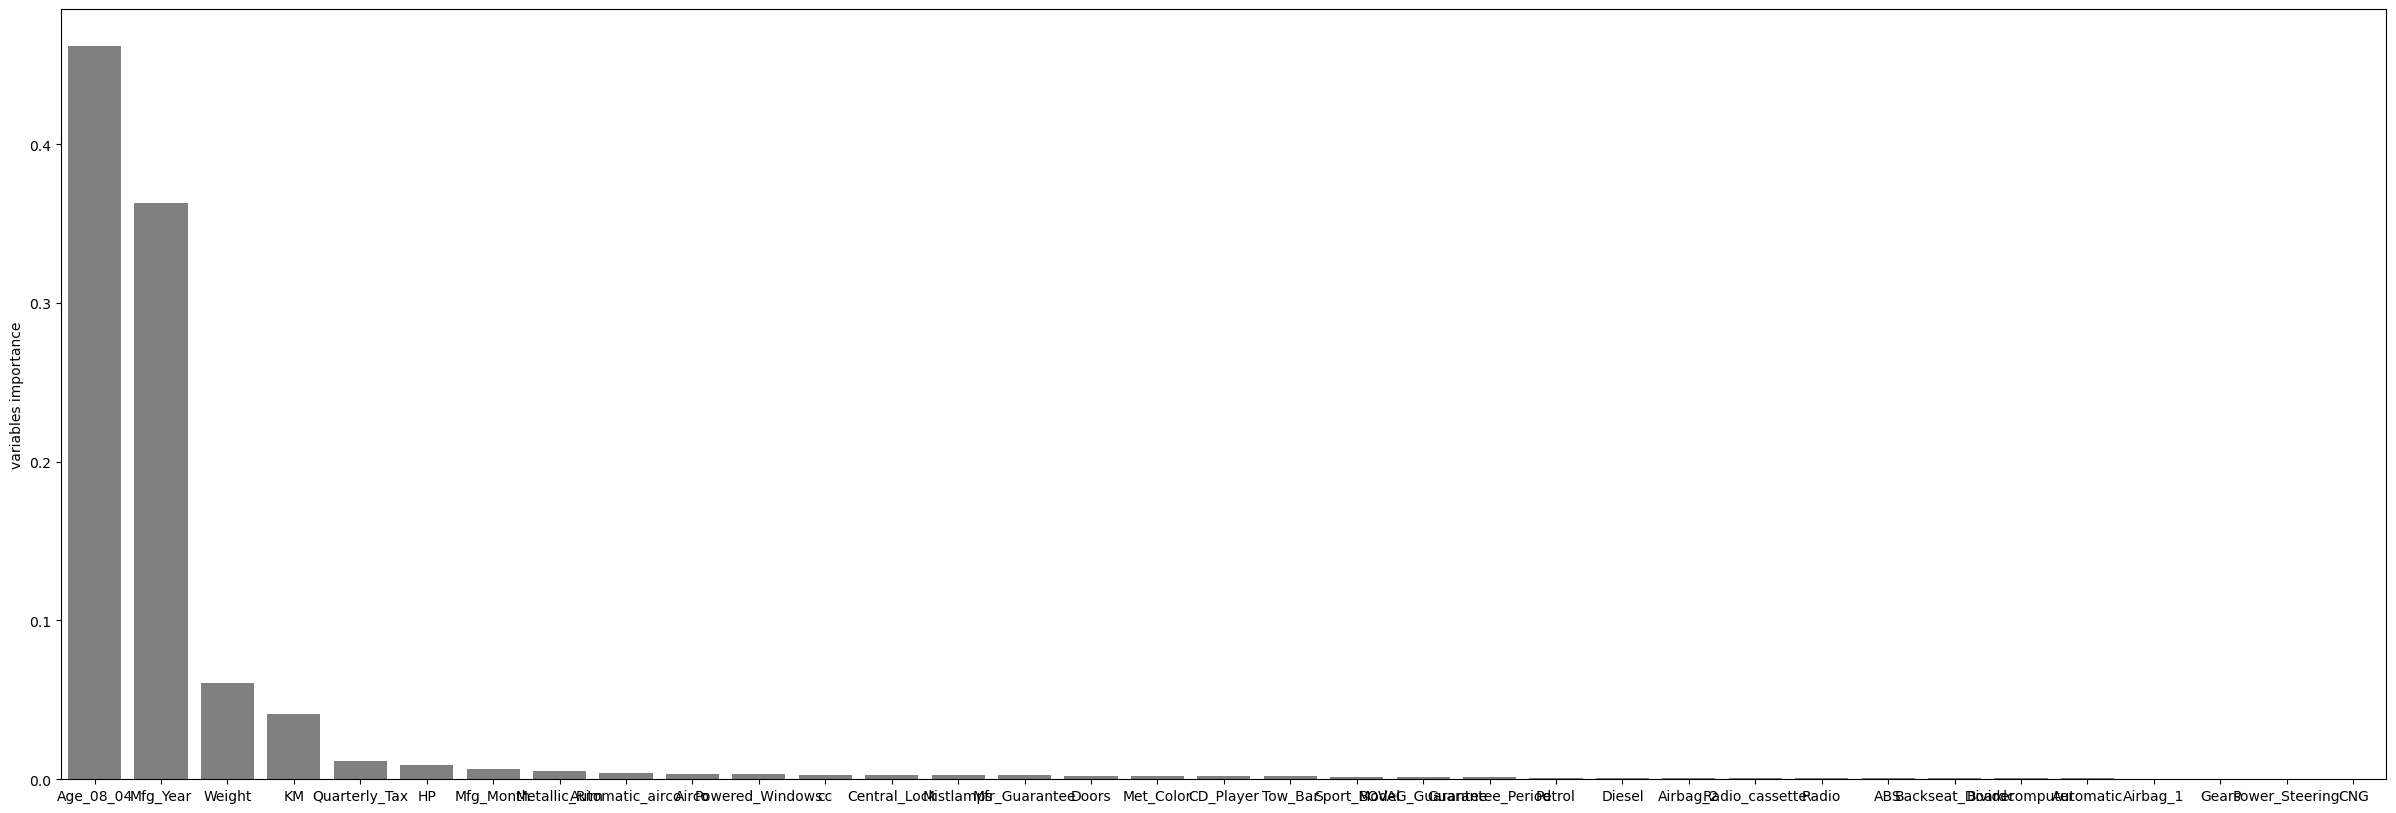

In [24]:
plt.figure(figsize=(30,10))
sns.barplot(
    x = var_imp_df.index,
    y = 'variables importance',
    color = 'grey',
    data = var_imp_df
)

In [25]:
# Prediction
RF_haty = RF_model.predict(tst_data.iloc[:,1:])

perf_table.iloc[4,:] = perf_eval(tst_data['Price'], RF_haty)
perf_table.round(4)

,MSE,RMSE,MAE,MAPE
MLR,2.337091e+06,1528.7547,1128.5443,0.1104
ANN,1.823912e+06,1350.5228,986.0619,0.1010
Bagging ANN,1.720403e+06,1311.6415,987.9617,0.1007
GBM,9.573357e+05,978.4353,741.5898,0.0741
Random Forests,9.934622e+05,996.7258,766.8441,0.0783
